In [1]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from helper.utils import *
from helper.model import *
from helper.distance_map import *
from helper.evaluate import *
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype =  torch.float32
print('device used: ', device)
torch.backends.cudnn.benchmark = True

checkpoint = torch.load('./model/uniref10/uniref10_split0_triplet.pth')
model = LayerNormNet(hidden_dim = 512, out_dim = 128, dtype=dtype, device=device)
model.load_state_dict(checkpoint)
model_triplet = model.to(device)
####### load supcon
checkpoint = torch.load('./model/uniref10/uniref10_split0_supcon.pth')
model = LayerNormNet(hidden_dim = 512, out_dim = 256, dtype=dtype, device=device)
model.load_state_dict(checkpoint)
model_supcon = model.to(device)
 

device used:  cuda:0


In [2]:
id_ec_dict, ec_id_dict = get_ec_id_dict_non_prom(
    './data/uniref10/uniref10_test_split_0_curate.csv')
id_ec = list(id_ec_dict.keys())
y = [id_ec_dict[id][0] for id in id_ec]
emb_triplet = model_embedding_test(id_ec_dict, model_triplet, device, dtype)
lookup_triplet = emb_triplet.detach().cpu().numpy()
emb_supcon = model_embedding_test(id_ec_dict, model_supcon, device, dtype)
lookup_supcon = emb_supcon.detach().cpu().numpy()
emb_esm = model_embedding_test(id_ec_dict, lambda *args: args[0], device, dtype)
lookup_esm = emb_esm.detach().cpu().numpy()

In [3]:
hard_ec = ['1.10.3.2', '1.3.1.98', '1.2.1.70', 
           '2.7.13.3', '2.7.4.3',  
           '3.6.4.12', '3.1.3.16',  
           '4.1.1.65', '4.1.1.65', 
             '5.1.1.1', '5.4.99.25', 
           '6.1.1.20', '6.3.4.19',  
           '7.1.1.2', '7.1.1.9'
           ]
# hard_ec = [ ]
# avoid_ec = ['3.6.4.13', '2.7.7.6', '2.3.2.27', '2.7.11.1', '5.2.1.8',]
#avoid_ec = []
avoid_ec = ['3.6.4.13',  '2.3.2.27', '2.7.11.1']

# avoid_ec = []
idx = []; idx_grey = []
for i, ec in enumerate(y):
    if (y.count(ec) >= 35 and ec not in avoid_ec) or (ec in hard_ec ):
        idx.append(i)
    else:
        idx_grey.append(i)

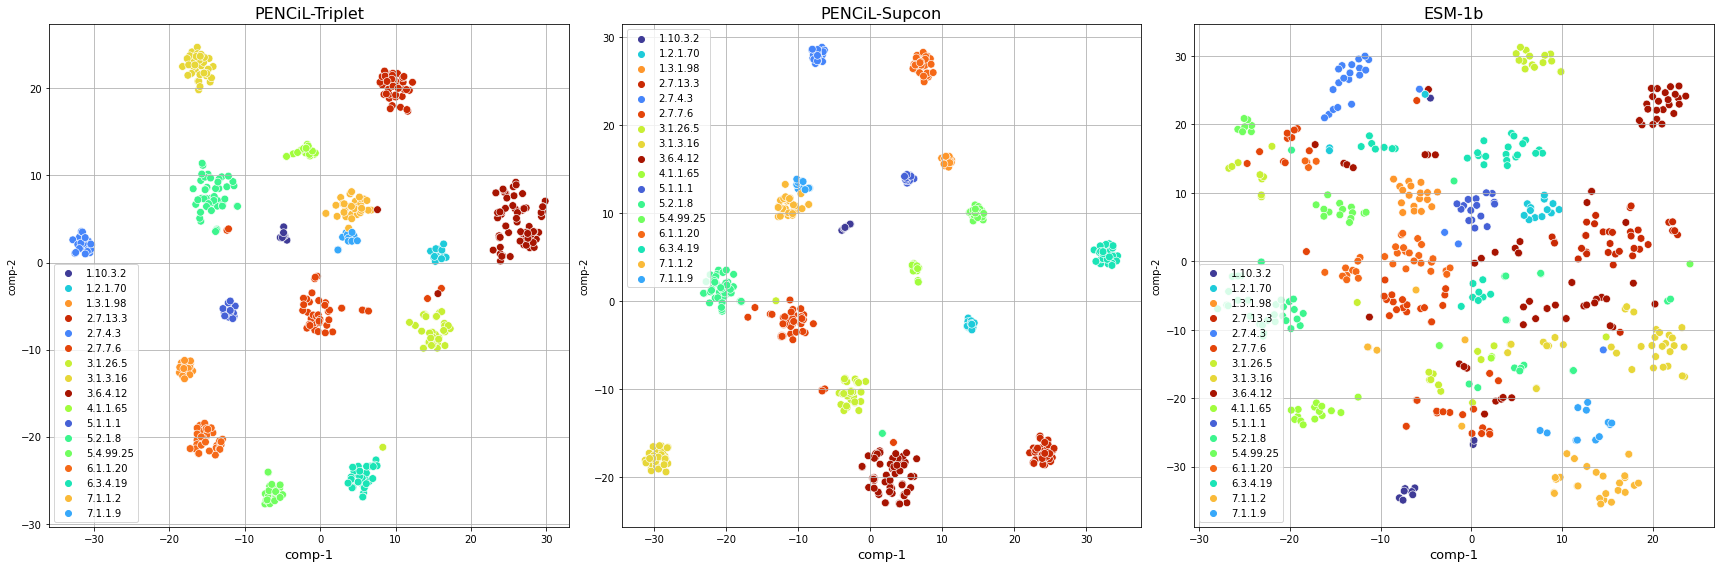

In [5]:
title_size =16; label_size = 13; legend_size=10
#############################################################################
fig = plt.figure(figsize=(24, 8))
ax1 = fig.add_subplot(131)
plt.grid()
ax2 = fig.add_subplot(132)
plt.grid()
ax3 = fig.add_subplot(133)
plt.grid()
#triplet results
tsne = TSNE(n_components=2, verbose=0, random_state=123, n_iter=750)
z = tsne.fit_transform(lookup_triplet[idx])
df = pd.DataFrame()
df["y"] = np.array(y)[idx]
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]
#print(len(set(np.array(y)[idx])))
sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df.y.tolist(), s=60,
                data=df, ax=ax1, palette='turbo_r')
handles, labels = ax1.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax1.legend(handles, labels, fontsize=legend_size)
ax1.set_title("PENCiL-Triplet", fontsize=title_size)
# supcon results
tsne = TSNE(n_components=2, verbose=0, random_state=123, n_iter=750)
z = tsne.fit_transform(lookup_supcon[idx])
df = pd.DataFrame()
df["y"] = np.array(y)[idx]
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]
#print(len(set(np.array(y)[idx])))
sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df.y.tolist(), s=60,
                data=df, ax=ax2, palette='turbo_r')
handles, labels = ax2.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax2.legend(handles, labels, fontsize=legend_size)
ax2.set_title("PENCiL-Supcon", fontsize=title_size)

# esm results
tsne = TSNE(n_components=2, verbose=0, random_state=123, n_iter=750)
z = tsne.fit_transform(lookup_esm[idx])
df = pd.DataFrame()
df["y"] = np.array(y)[idx]
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]
#print(len(set(np.array(y)[idx])))
sns.scatterplot(x="comp-1", y="comp-2", legend='brief', hue=df.y.tolist(), s=60,
                data=df, ax=ax3, palette='turbo_r')
handles, labels = ax3.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax3.legend(handles, labels, fontsize=legend_size)
ax3.set_title("ESM-1b", fontsize=title_size)
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=label_size)
fig.savefig('../t-SNE.png')